In [1]:
using Pkg 

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra
using StatsBase
using Distributions
using JLD2
using Random

using CairoMakie

  Activating project at `~/Projects/MiCRM_stability`
[ Info: Precompiling MiCRM_stability [b18b2576-abff-478e-9c74-99a4a11eb715]
[ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
Precompiling CairoMakie
  ✓ libsixel_jll
  ✓ ConstructionBase → ConstructionBaseStaticArraysExt
  ✓ Libglvnd_jll
  ✓ libass_jll
  ✓ Packing
  ✓ StructArrays → StructArraysStaticArraysExt
  ✓ libwebp_jll
  ✓ ShaderAbstractions
  ✓ FFMPEG_jll
  ✓ ExactPredicates
  ✓ ColorVectorSpace → SpecialFunctionsExt
  ✓ SpecialFunctions → SpecialFunctionsChainRulesCoreExt
  ✓ WebP
  ✓ FreeTypeAbstraction
  ✓ JpegTurbo
  ✓ Sixel
  ✓ ImageBase
  ✓ DelaunayTriangulation
  ✓ StatsFuns → StatsFunsInverseFunctionsExt
  ✓ ImageAxes
  ✓ StatsFuns → StatsFunsChainRulesCoreExt
  ✓ ImageMetadata
  ✓ Netpbm
  ✓ MathTeXEngine
  ✓ Distributions → DistributionsChainRulesCoreExt
  ✓ KernelDensity
  ✓ Makie
  ✓ CairoMakie
  28 dependencies successfully precompiled in 113 seconds. 210 already precompiled.
[ Info: Precompiling 

In [7]:
#get parameter names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)
fs = filter(x -> x ∉ [:χ,:D, :ϕ_norm_inv,:γ, :η], fs)
    
names_ =  vcat(fe...,fs..., "Cu", "Cd")

# #latex names
fe_L = [L"g^{(x)}",L"g^{(s)}",L"m^{(x)}",L"f^{(y)}",L"\lambda^{(g)}",L"i^{(y)}",L"o^{(y)}"]
fs_L = [L"\alpha",L"\beta",L"\Lambda^*",L"\Omega^*",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"C_U", L"C_D"]

# # #concatanate
names_ = string.(names_)
names_L = vcat(fe_L,fs_L)

# # #load
res = load("../Results/data/new_sims/dynamic_stabiltiy.jld2")

Dict{String, Any} with 5 entries:
  "v" => Vector{Any}[[0.0273607+0.0im, 0.0228849+0.0im, 0.0496592+0.0im, 0.0439…
  "c" => Complex[-0.384984+0.0im, -0.0903744+0.0im, -0.03473+0.0im, -0.160102+0…
  "r" => Complex[0.066501+0.0im, -0.00622833+0.0im, 0.271589+0.0im, 0.128678+0.…
  "l" => Complex[0.0622456+0.0im, -0.0145353+0.0im, 0.267693+0.0im, 0.128567+0.…
  "p" => Any[[0.425891, 2.00568, 0.84149, 0.429404, 1.82832, 0.315578, 0.523174…

In [8]:
stab = (real(res["l"]) .< 0) 
r_stab = (real(res["r"]) .< 0) 
c_stab = (real(res["c"]) .< 0);

println("overall stable: ", mean(stab))
println("resource stable: ", mean(r_stab))
println("consumer stable: ", mean(c_stab))


stab |> sum

overall stable: 0.60783
resource stable: 0.64423
consumer stable: 0.92135


60783

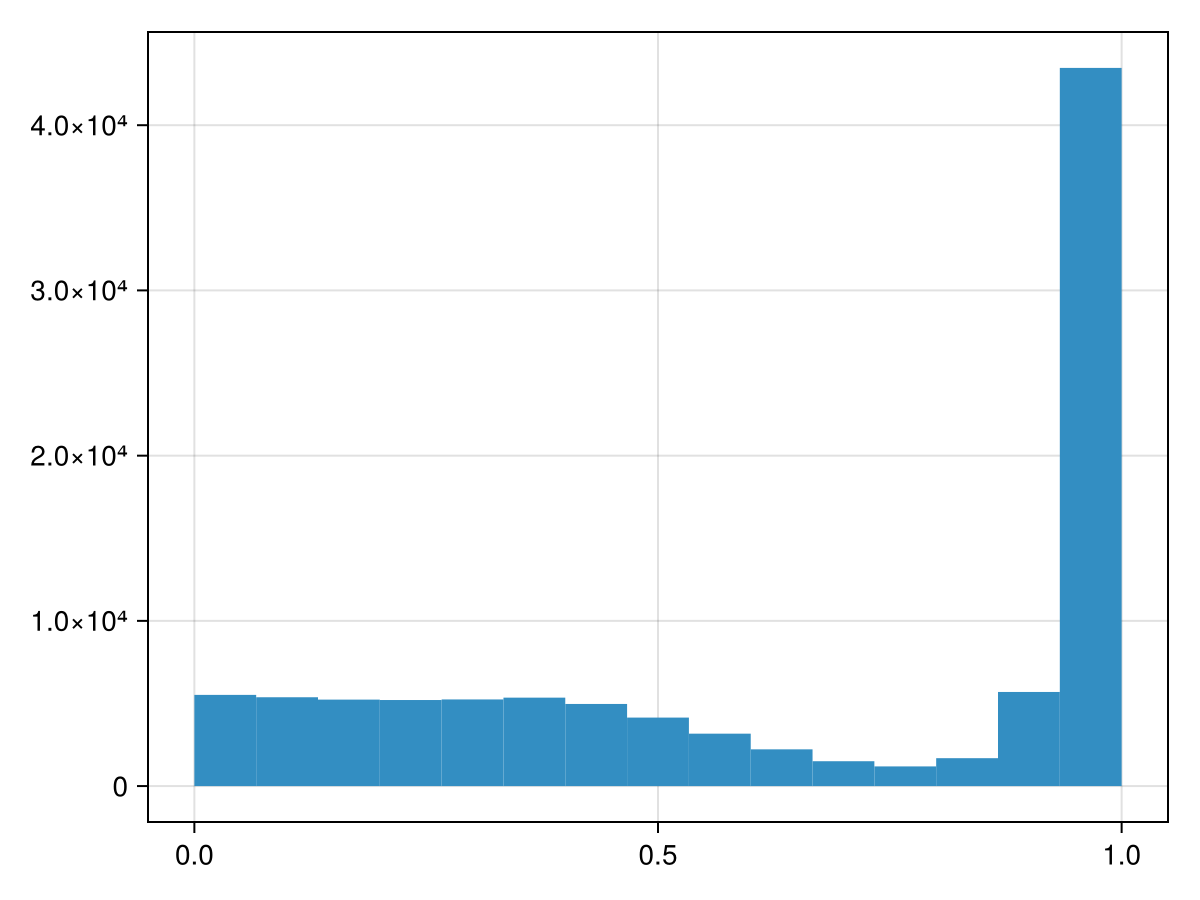

In [9]:
a = [norm(v[1:100]) for v = res["v"]]
b = [norm(v[101:200]) for v = res["v"]]


a ./ (a .+ b) |> hist

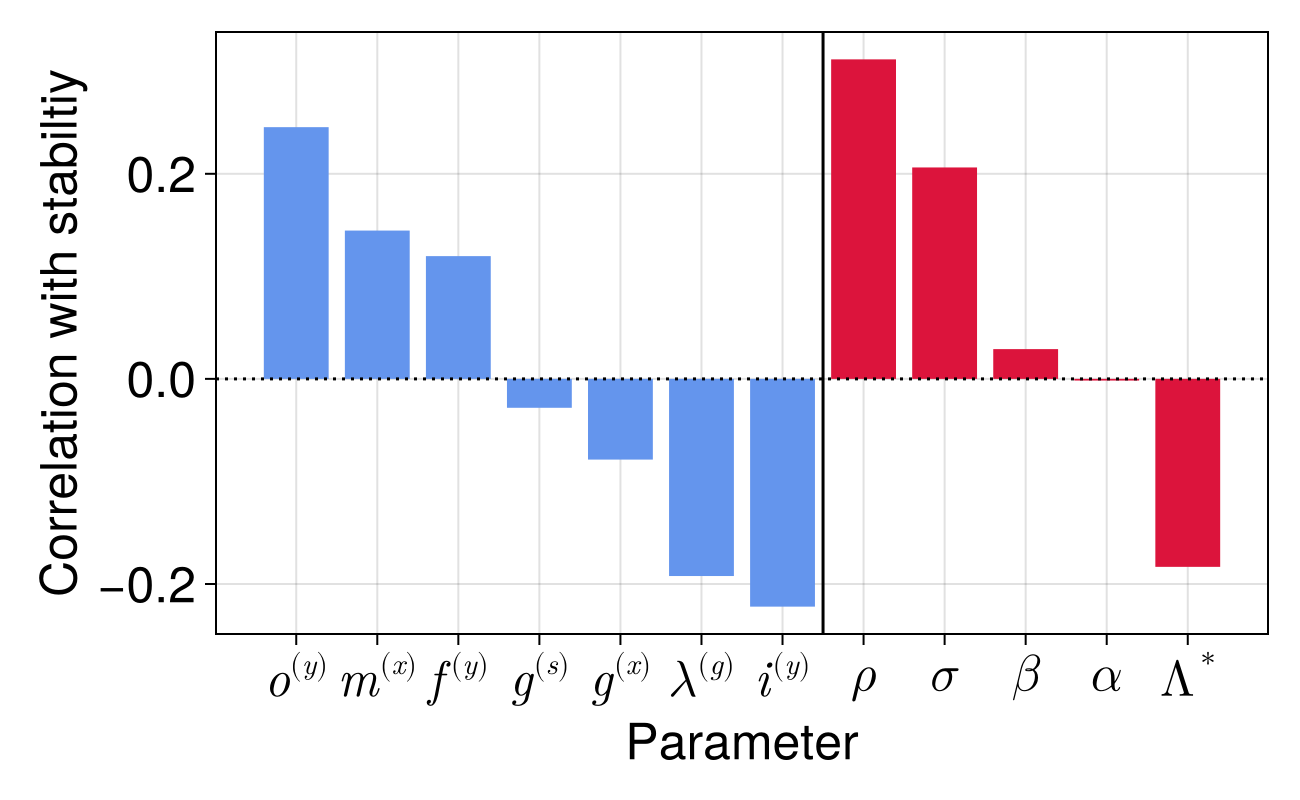

In [10]:
# #filter parameters
p_ind = collect(eachindex(names_))
rm_ind = findall(names_ .∈ Ref(["γ","η","χ","ϕ","σ̃","ρ̃","Ω","Cu","Cd"]))
p_ind = filter(x -> x .∉ Ref(rm_ind), p_ind)

#filter name vectors
names_1 = names_[p_ind]
names_L_1 = names_L[p_ind]

#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(p, stab) for p = eachrow(p_mat)]
 
# #get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

# # #sortnames
# ind = sortperm((stability_cor),rev=true)
ind = vcat(sortperm((stability_cor[1:7]),rev=true), 7 .+ sortperm((stability_cor[8:12]),rev=true))

f = Figure(size = (650,400))
ax = Axis(f[1,1], xticks = (1:length(names_1), names_L_1[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

barplot!(ax, stability_cor[ind], color = c)
hlines!(ax, [0], linestyle = :dot, color = "black")
vlines!(ax, [7.5], color = :black)

# ylims!(ax,-0.5, 0.5)

f

In [14]:
save("../Results/Figures/stability_correlations.pdf", f)

CairoMakie.Screen{PDF}


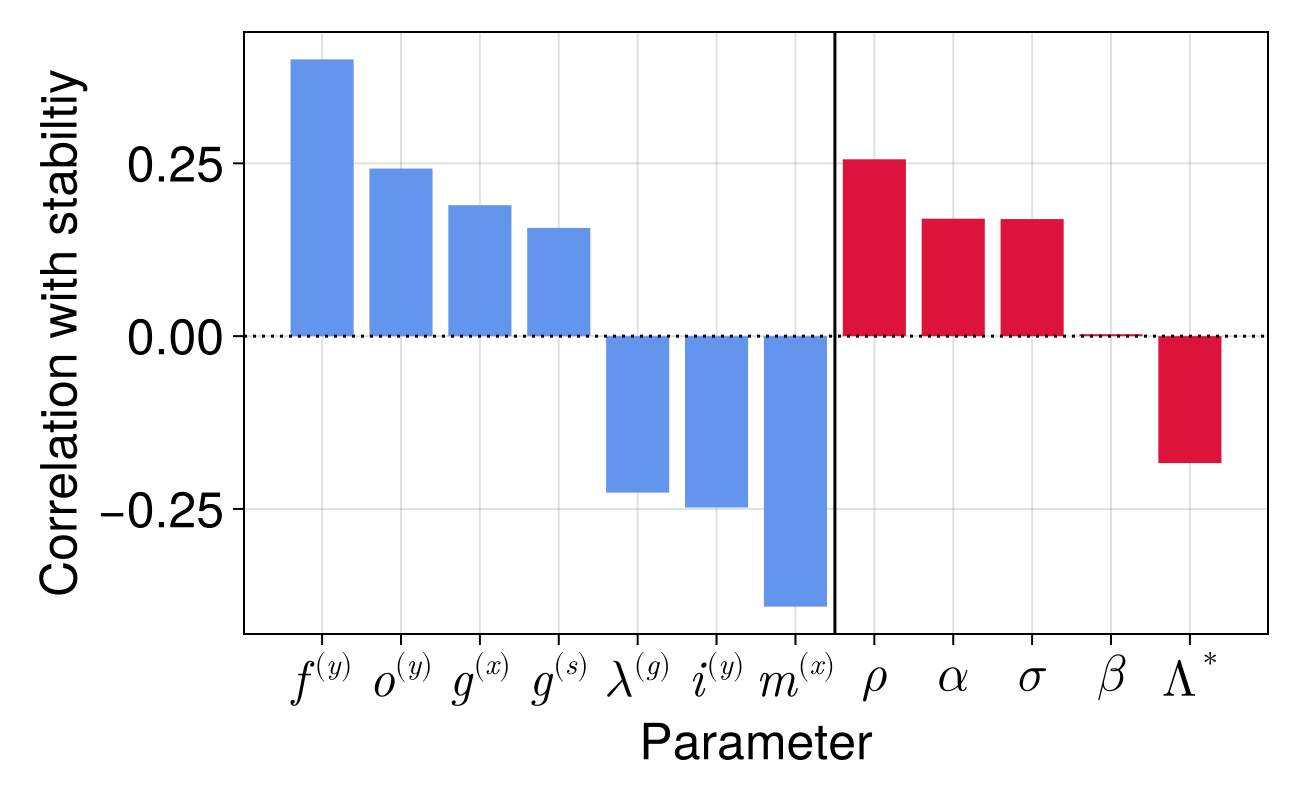

In [34]:
instab = .!stab

v = [norm(v[1:100])^2 for v = res["v"]]
con_cor = [cor(p[instab], v[instab]) for p = eachrow(p_mat)]

# #get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

# # #sortnames
# ind = sortperm((stability_cor),rev=true)
ind = vcat(sortperm((con_cor[1:7]),rev=true), 7 .+ sortperm((con_cor[8:12]),rev=true))

f = Figure(size = (650,400))
ax = Axis(f[1,1], xticks = (1:length(names_1), names_L_1[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

barplot!(ax, con_cor[ind], color = c)
hlines!(ax, [0], linestyle = :dot, color = "black")
vlines!(ax, [7.5], color = :black)

# ylims!(ax,-0.5, 0.5)

f

In [27]:
 + norm(v[101:end])^2

1.0000000000000036

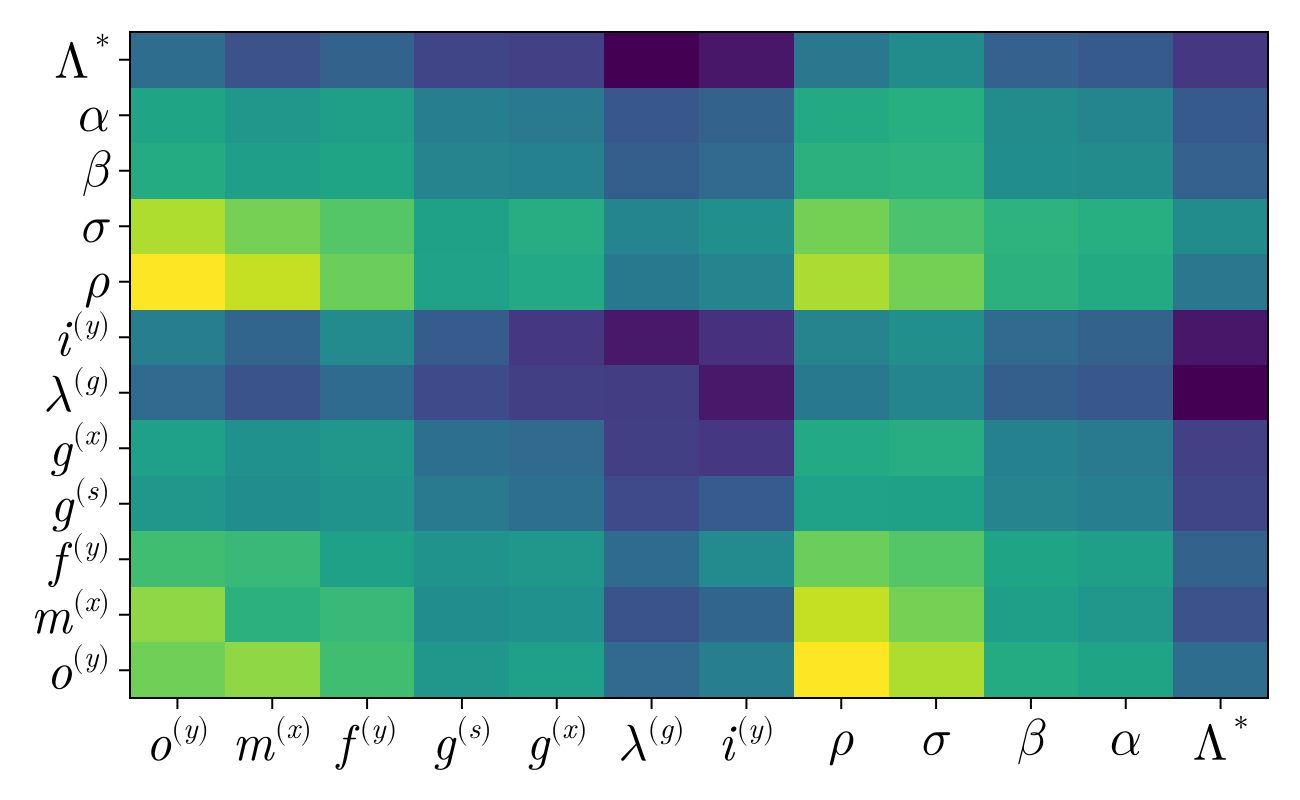

In [9]:
p_mat_interact = zeros(12,12, 100000)

for i = 1:12
    for j = 1:12
        p_mat_interact[i,j, :] .= p_mat[i,:] .* p_mat[j,:]
    end
end

cor_mat = zeros(12,12) 
for i = 1:12
    for j = 1:12
        cor_mat[i,j] = cor(p_mat_interact[i,j,:], stab)
    end
end

f = Figure(size = (650,400))
ax = Axis(f[1,1], xticks = (1:length(names_1), names_L_1[ind]), 
    yticks = (1:length(names_1), names_L_1[ind]),
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

heatmap!(ax, cor_mat[ind,ind])

f

# size

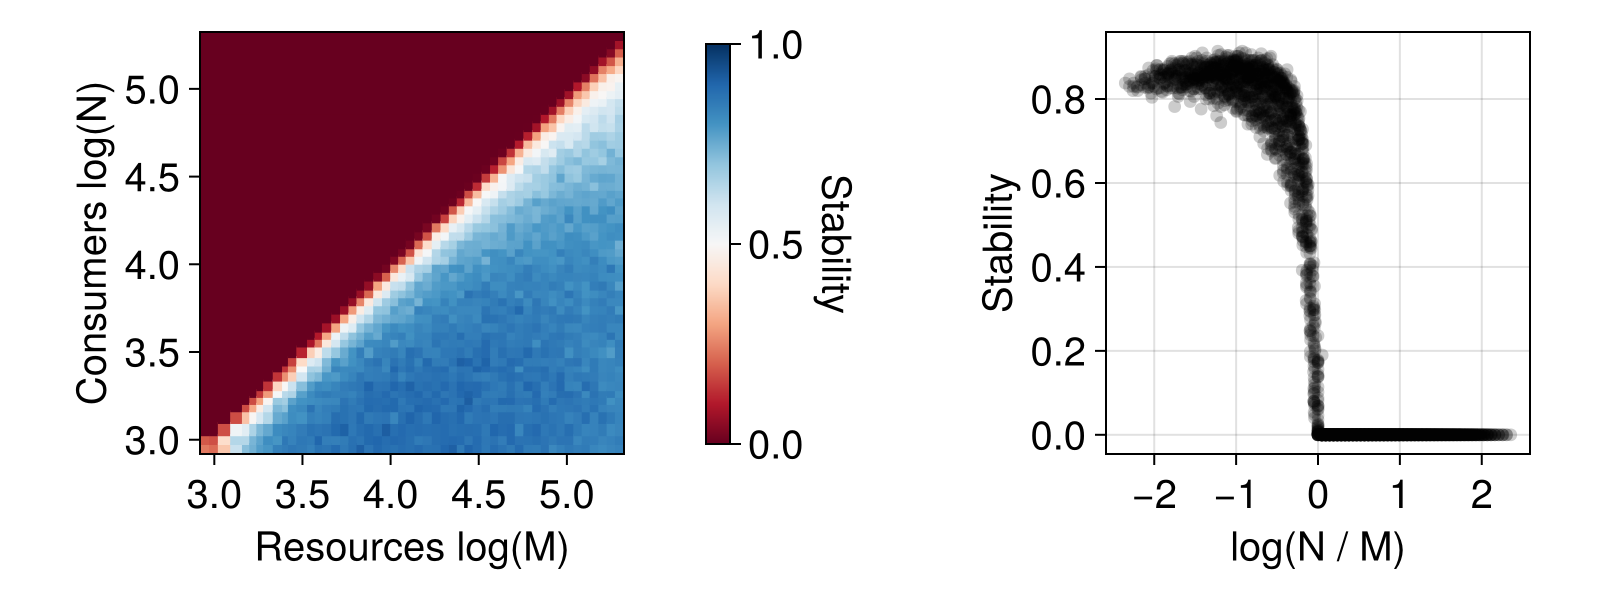

In [35]:
res = load("../Results/data/new_sims/size_stability.jld2")
stab = [(x.re) .< -1e-6 for x = res["l"]]

#params
#params
N = 50
M = 50
Np = 1000

n_vec = Int.(floor.(10 .^ range(log10(20), log10(200), length = N)))
m_vec = Int.(floor.(10 .^ range(log10(20), log10(200), length = M)))

#fix graphical errorr
n_vec[1] = 19
m_vec[1] = 19

N_mat = [n_vec[i] for i = 1:N, j = 1:M]
M_mat = [m_vec[j] for i = 1:N, j = 1:M]

stab = mean(stab,dims=3)[:,:,1]

f = Figure(size = (800,300))

#plot stabiltiy heatmap
ax = Axis(f[1,1], ylabel = "Consumers log(N)", xlabel = "Resources log(M)", aspect = 1, xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)
cm = :RdBu

heatmap!(ax, log.(m_vec), log.(n_vec), (stab'), colormap = (cm), colorrange = (0,1))
Colorbar(f[1,2], colormap = (cm), label = "Stability", 
    flip_vertical_label = true, labelsize = 20, ticklabelsize = 20, tellheight = false, height = 200)

# cm = :RdBu

ax2 = Axis(f[1,3], aspect = 1, ylabel = "Stability", xlabel = "log(N / M)", xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)

scatter!(ax2, log.(N_mat[:] ./ M_mat[:]), stab[:] ,  colormap = (:Blues), color = (:black, 0.2))

colsize!(f.layout, 2, Relative(0.1))
# rowgap!(f.layout,1, Relative(0.1))
colgap!(f.layout,1 ,0.0)

f

In [75]:
save("../Results/Figures/size_correlations.pdf", f)

CairoMakie.Screen{PDF}


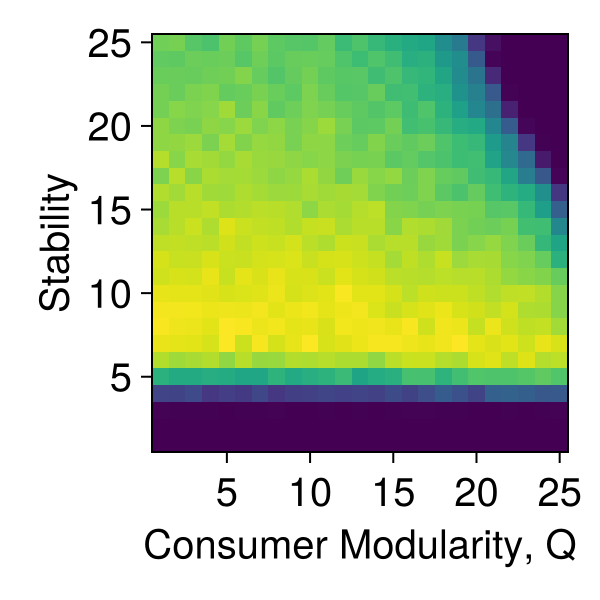

In [51]:
res = load("../Results/data/new_sims/mod_stability.jld2")
stab = [(x.re) .< -1e-6 for x = res["l"]]
stab = mean(stab, dims = (3))[:,:,1]

f = Figure(size = (300,300))

#plot stabiltiy heatmap
ax = Axis(f[1,1], ylabel = "Stability", xlabel = "Consumer Modularity, Q", aspect = 1, xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)

cm = :RdBu

heatmap!(ax, stab)

f

In [48]:
stab

25×25 Matrix{Float64}:
 0.927  0.923  0.924  0.912  0.934  …  0.923  0.933  0.928  0.932  0.922
 0.919  0.94   0.927  0.928  0.928     0.938  0.935  0.94   0.922  0.918
 0.936  0.921  0.927  0.938  0.932     0.951  0.93   0.924  0.924  0.939
 0.924  0.931  0.93   0.93   0.937     0.936  0.928  0.936  0.932  0.941
 0.926  0.937  0.928  0.942  0.927     0.932  0.93   0.92   0.942  0.926
 0.933  0.94   0.936  0.932  0.946  …  0.936  0.946  0.911  0.947  0.936
 0.926  0.933  0.946  0.932  0.941     0.926  0.923  0.937  0.94   0.942
 0.935  0.931  0.92   0.925  0.94      0.932  0.947  0.926  0.934  0.941
 0.928  0.92   0.93   0.929  0.948     0.924  0.937  0.924  0.936  0.922
 0.93   0.942  0.932  0.935  0.931     0.925  0.921  0.923  0.936  0.936
 0.929  0.926  0.926  0.918  0.94   …  0.922  0.93   0.92   0.932  0.918
 0.94   0.934  0.94   0.929  0.926     0.915  0.934  0.929  0.936  0.919
 0.926  0.919  0.915  0.905  0.908     0.925  0.935  0.922  0.928  0.926
 0.92   0.932  0.926  0.908 

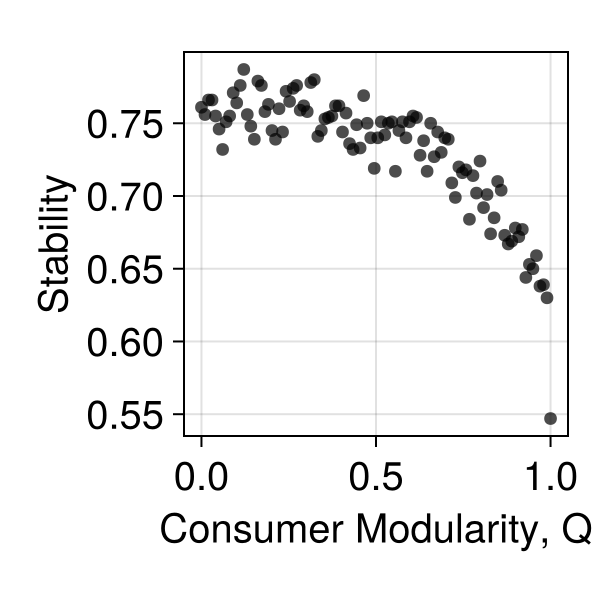

In [154]:
res = load("../Results/data/new_sims/coherence_stabiltiy.jld2")
stab = [(x.re) .< -1e-6 for x = res["l"]]
stab = mean(stab, dims = (2))[:,1]

f = Figure(size = (300,300))

#plot stabiltiy heatmap
ax = Axis(f[1,1], ylabel = "Stability", xlabel = "Consumer Modularity, Q", aspect = 1, xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)

cm = :RdBu

plot!(ax, range(0,1,length = 100), stab, color = (:black, 0.7))

f

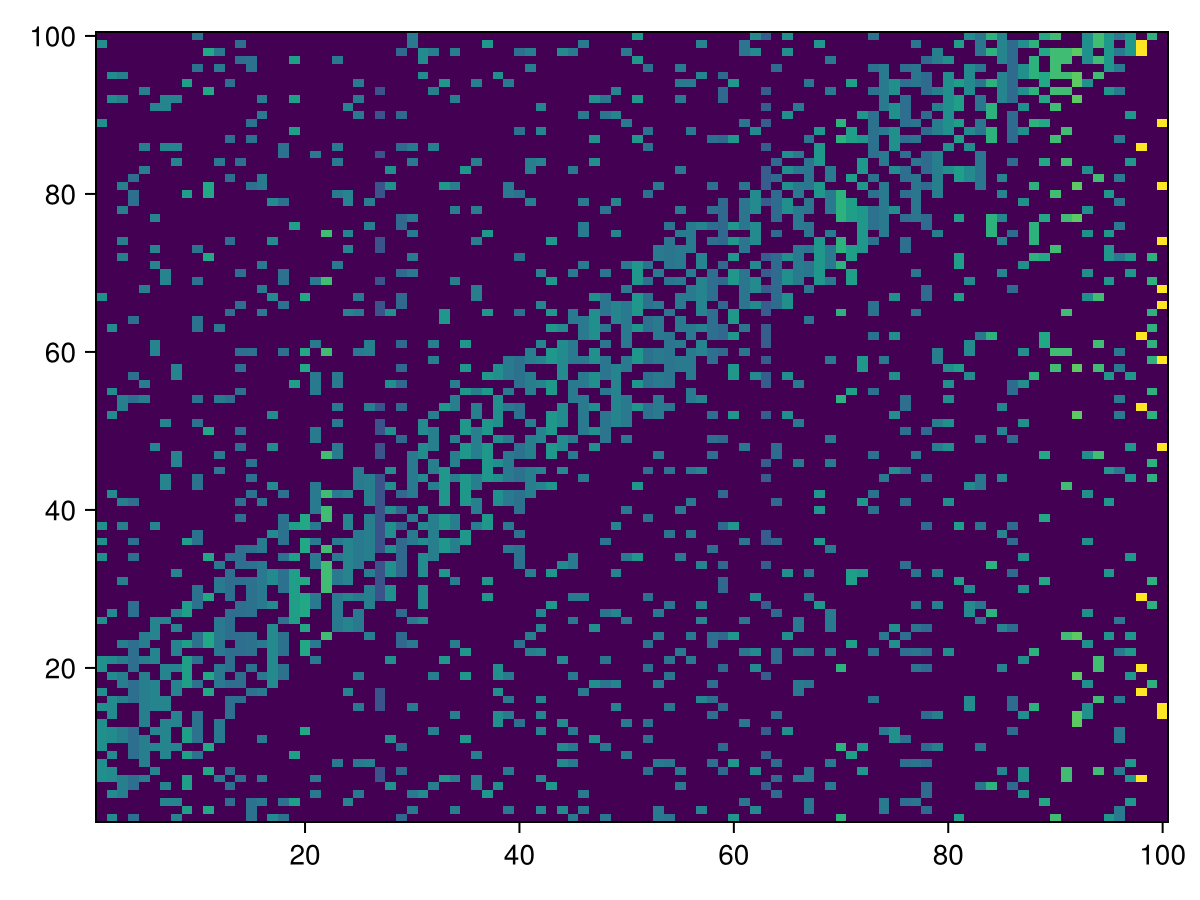

In [152]:
p = MiCRM_stability.hierarchical_community(100,100,5,20, 1.0, 0.5,2000, 2000)

p.D |> heatmap

In [27]:
# functions for simulations
function get_exponential_parameters(N::Int64,M::Int64,σ::Float64)
    gx = rand(Uniform(0,1),N) 
    gs = rand(Uniform(0,2), N)
    mx = gx
    
    fy = rand(Uniform(1,2),N,M) 
    λy = zeros(N)

    iy = zeros(M)
    oy = rand(Uniform(0.5,1.5), M)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end


function random_community(N,M,f)
    #fixed consumption per consumer
    #fixed leakage per resource
    c = MiCRM_stability.random_community(N,M, 10 / N, 10 / M)

    Λ = rand(Uniform(0.1,0.8)) .+ rand(Uniform(-0.1,0.1),N) 
    G = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),N) 
    α = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    β = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    C_pert = rand(Uniform(0.1,1.0)) .+ rand(Uniform(-0.1,0.1),M) 
    
    s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, G, α, β, C_pert)
    e = f(N,M, 0.1)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p)
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

function inner(r)
    for i = 1:nN
        for j = 1:nM

            println(i, "  ", j)

            N = n_vec[i]
            M = m_vec[j]
            
            #param
            p = random_community(N, M, get_exponential_parameters)
            #jaccobian
            J = zeros(N + M, N + M)
            MiCRM_stability.jacobian!(p, J)
            try 
                stability[i,j,r] = get_real(eigsolve(J, 1, (:LR))[1][1])  
            catch
                stability[i,j,r] = 0.0
            end
        end
    end
end

inner (generic function with 1 method)

In [28]:
p = random_community(200, 20, get_exponential_parameters)

MiCRM_stability.Parameters(200, 20, MiCRM_stability.structural_params([0.16416884630759915, 0.09178676220467136, 0.22702237799645664, 0.2647222202564403, 0.16647802374887138, 0.11427041315281683, 0.16037828068249585, 0.2450725498233672, 0.14013480041032453, 0.13679055121215083, 0.10347882975781295, 0.22223985434061944, 0.18564432924706342, 0.2799217613441769, 0.15670719963222404, 0.10740965839164926, 0.11771139839081707, 0.14479181689952036, 0.22880422638998796, 0.09561710239196541], [0.9690827840324916, 0.9048022167025496, 0.8895354426262098, 1.0019009436195203, 0.9261435351916887, 0.9867749753871253, 1.0573706282000273, 1.01242342933198, 1.065937820021539, 1.074507825908382, 1.0295649280988988, 0.938534630946938, 0.8921384755411376, 0.9867917623064535, 1.0566052434803637, 0.9113107990128396, 0.9928707546267335, 0.9079094865758206, 1.0293182091197175, 0.9124493233669565], [0.4393004283471869, 0.4252368760263312, 0.5608045149379142, 0.49016289783595907, 0.5540485459436159, 0.5203873220

In [61]:
# functions for simulations
function get_exponential_parameters(N::Int64,M::Int64,σ::Float64,K::Float64)
    gx = rand(Uniform(0,1),N) 
    gs = rand(Uniform(0,2), N)
    mx = gx
    
    fy = rand(Uniform(1,2),N,M) 
    λy = zeros(N)

    iy = zeros(M)
    oy = rand(Uniform(0.5,1.5), M)

    return MiCRM_stability.exponential_params(gx,gs,mx,fy,λy,iy,oy)
end


function random_community(N,M,f, K, Λv)
    c = MiCRM_stability.random_community(N,M, rand(), rand())

    while any(sum(c.U, dims = 2) .== 0)
        c = MiCRM_stability.random_community(N,M, rand(), rand())
    end

    Λ = fill(Λv, N)
    I = rand(M) * 0.25
    s = MiCRM_stability.get_structural_params(c.N, c.M, c.U,c.D, Λ, 1.0)
    e = f(N,M, 0.1, 0.0)
    
    p = MiCRM_stability.Parameters(N,M,s,e)

    return(p)
end

random_community (generic function with 2 methods)

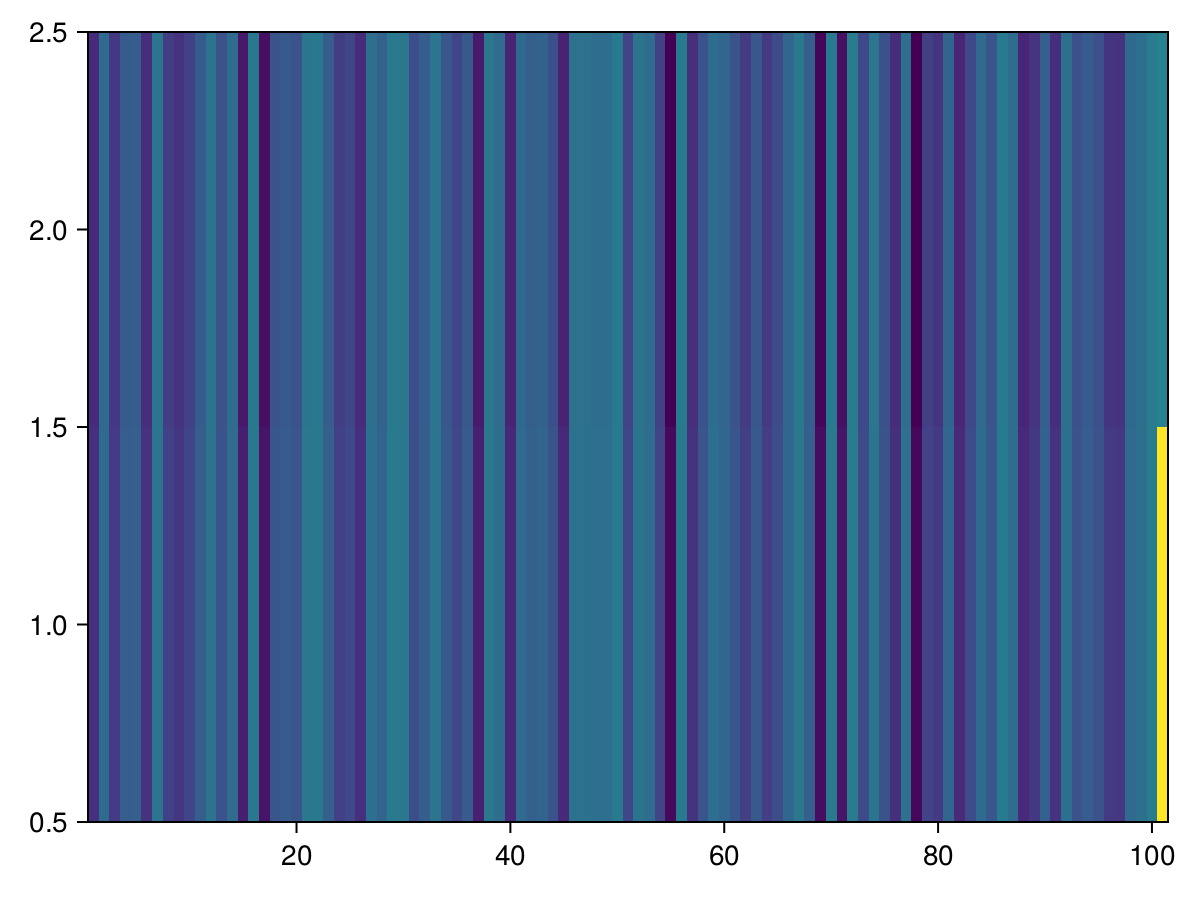

In [68]:
#param
N = 100
M = 1
p = random_community(N, M, get_exponential_parameters, 1.0, 0.5)


#jaccobian
J = zeros(N + M, N + M)
MiCRM_stability.jacobian!(p, J)

e = J |> eigen

real.(e.vectors[:,1:2]) |> heatmap

In [11]:
save("../Results/Figures/size_correlations.svg", f)
save("../Results/Figures/size_correlations.pdf", f)

CairoMakie.Screen{PDF}


In [14]:
using GLM

res = load("../Results/data/new_sims/size_stability.jld2")

stab = [(x.re) .< -eps()  for x = res["l"]];
stab = mean(stab[:,:,:,:], dims = 3)[:,:,1,:]

n = 10
k = 4

f = Figure(size = (1200,400))
ax = Axis(f[1,1])
heatmap!(ax,log10.(n_vec[n] ./ m_vec), log10.(k_vec), stab[n,:,:], colormap = :RdBu, colorrange = (0,1))
hlines!(ax, log10.(k_vec)[k], color = :black)

ax = Axis(f[1,2])
for i = eachindex(n_vec)
    c = m_vec
    α = 0.5
    scatter!(ax, log10.(n_vec[i] ./ (m_vec))  , stab[i,:,k], color = c, colorrange = extrema(c), colormap = :RdBu)

    X = n_vec[i] ./ (m_vec .^ α)  
    Y = stab[i,:,k]
    # mask = X .<= 7.0

    # data = (; X = X[mask], Y = Y[mask])
    # mod = lm(@formula(Y~X), data)
    # ablines!(ax, GLM.coef(mod)...)

    # println(GLM.coef(mod))
    
end

ax = Axis(f[1,3])
for i = eachindex(m_vec)
    c = n_vec[n] / m_vec[i]
    scatter!(ax, log10.(k_vec) , stab[n,i,:], color  = fill(m_vec[i], length(stab[n,i,:])), colorrange = extrema(m_vec), colormap = :RdBu)
end

f

LoadError: BoundsError: attempt to access 10×10×1 Array{Float64, 3} at index [1, 1:10, 4]

In [62]:
using Interpolations, Statistics

α=1.0

function mr_f(α)
    x = N_mat[2:end,2:end] ./ M_mat[2:end, 2:end].^α
    y = log10.(stab[2:end, 2:end])
    
    
    x_grid = range(0.1,3.0, length = 100)  
    interp = zeros(M-1,100)
    # # Define a common x-grid to interpolate onto
    for i = 1:(M-1)
        itp = LinearInterpolation(x[:,i], y[:,i], extrapolation_bc=NaN)
        interp[i,:] = itp.(x_grid) 
    end
    
    interp[isnan.(interp)] .= -Inf
    
    resid = (interp .- [mean(interp[interp[:,i] .> -Inf,i]) for i = 1:100]') .^ 2
    mr = [resid[.!isnan.(resid[:,i]) .&& resid[:,i] .< Inf,i] |> mean for i = 1:100]
    tot_r = mr[.!isnan.(mr)] |> mean
end

mr_f (generic function with 1 method)

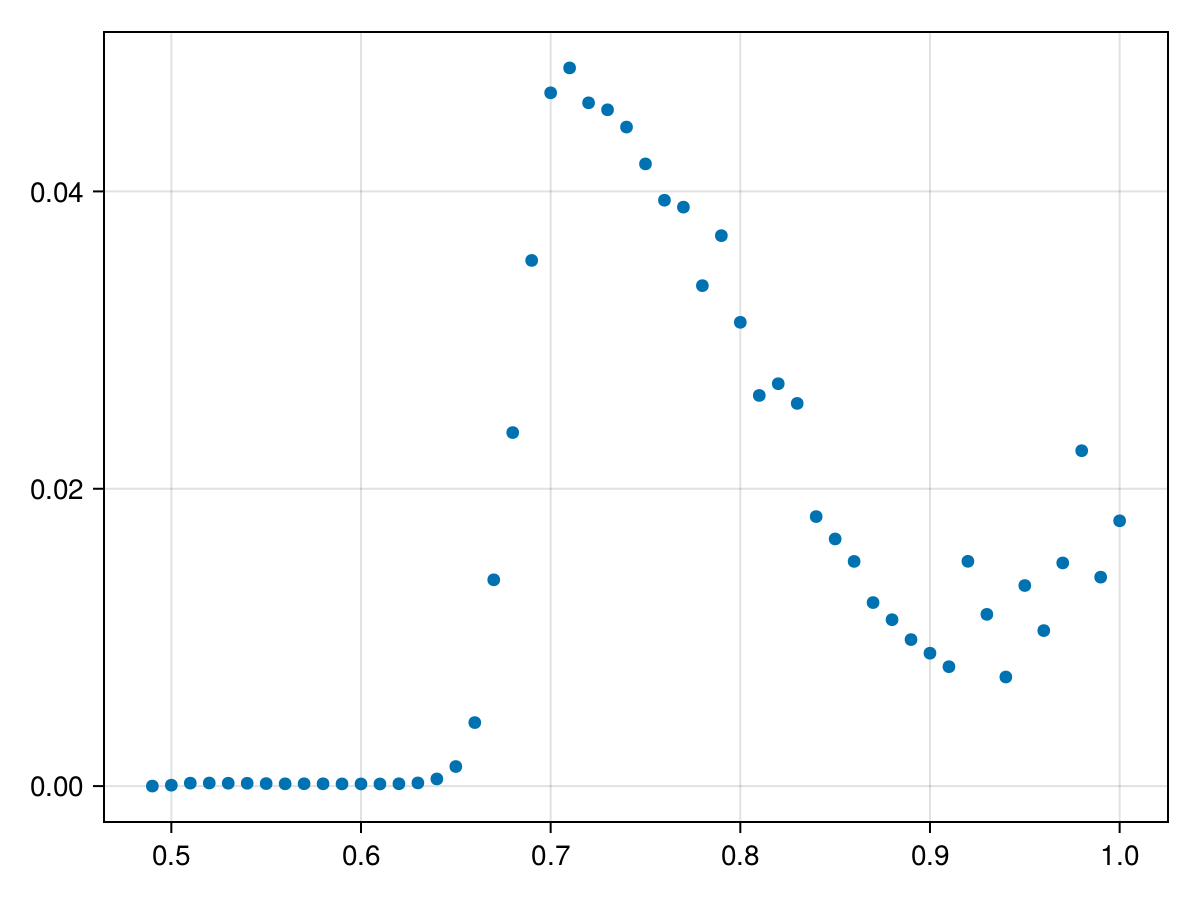

In [63]:
x = 0.1: 0.01 : 1.0
y = mr_f.(x)

plot(x[.!isnan.(y)], y[.!isnan.(y)])

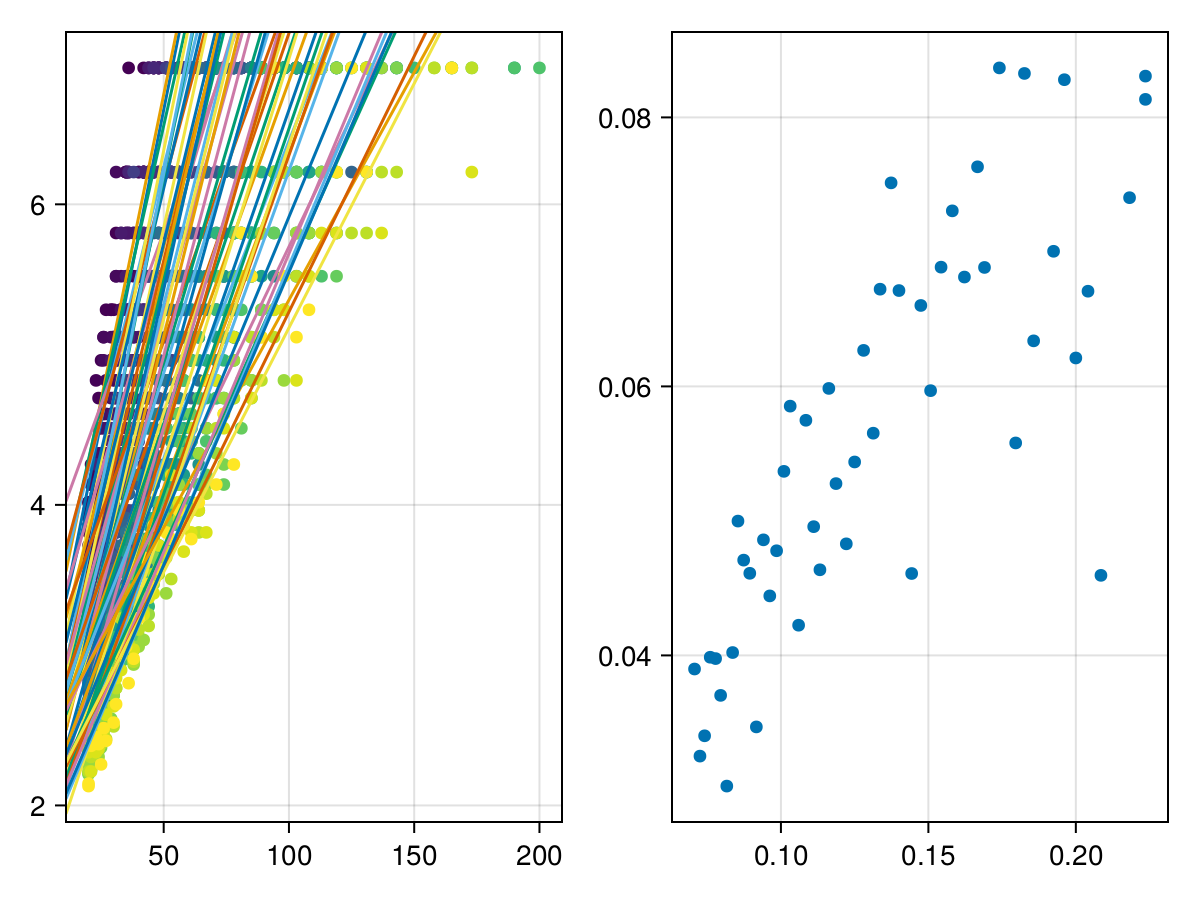

In [248]:
ind = stab[:] .> 0
f,ax = scatter(N_mat[ind], -log.(stab[ind]), color = M_mat[ind])

a_vec = zeros(M)
for i = 1:M
    ind = stab[:,i] .> 0
    x = N_mat[ind,i]
    y = -log.(stab[ind,i])

    data = (; x, y)
    mod = lm(@formula(y~x), data)
    ablines!(ax, GLM.coef(mod)...)

    a_vec[i] = GLM.coef(mod)[2]
end

ax2 = Axis(f[1,2])
scatter!(ax2, 1 ./ sqrt.(m_vec), a_vec)

f

In [250]:
x = 1 ./ sqrt.(m_vec)
y = a_vec
data = (; x, y)
    mod = lm(@formula(y~x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.0216711   0.0039482  5.49    <1e-05  0.0137327  0.0296095
x            0.262734    0.027928   9.41    <1e-11  0.206581   0.318887
────────────────────────────────────────────────────────────────────────

In [20]:
save("../Results/Figures/size_correlations.pdf", f)
save("../Results/Figures/size_correlations.svg", f)

CairoMakie.Screen{SVG}


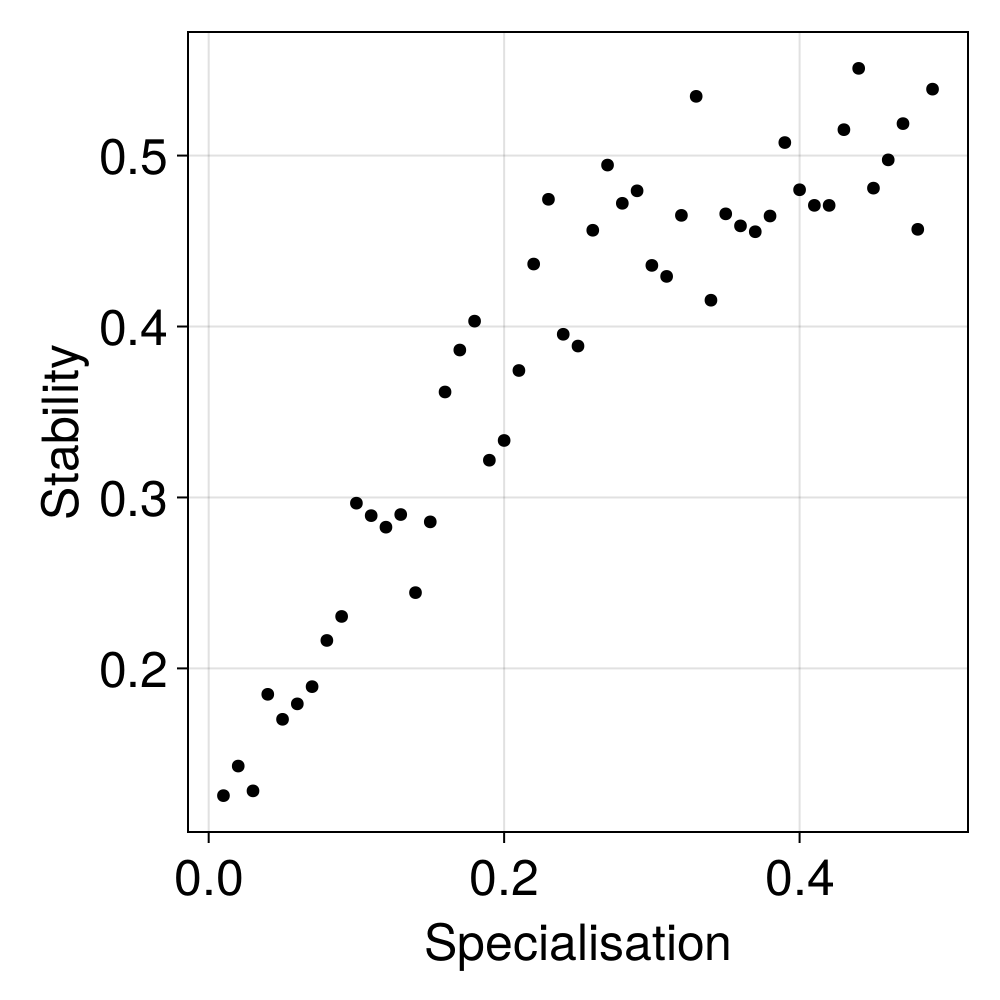

In [13]:
res = load("../Results/data/new_sims/overlap_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]
pvec = hcat(res["p"]...)

d = 0.01
xvec = d:d:1.0
stab_var = [stab[(i .< pvec[1,:] .< i + d)] |> var for i = xvec]
stab = [stab[(i .< pvec[1,:] .< i + d)] |> mean for i = xvec]

f = Figure(size = (500,500))
ax = Axis(f[1,1], xlabel = "Specialisation", ylabel = "Stability", 
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

plot!(ax, xvec, stab, color = (:black))
# errorbars!(ax, xvec,stab, stab_var)
# ylims!(0,1)

f

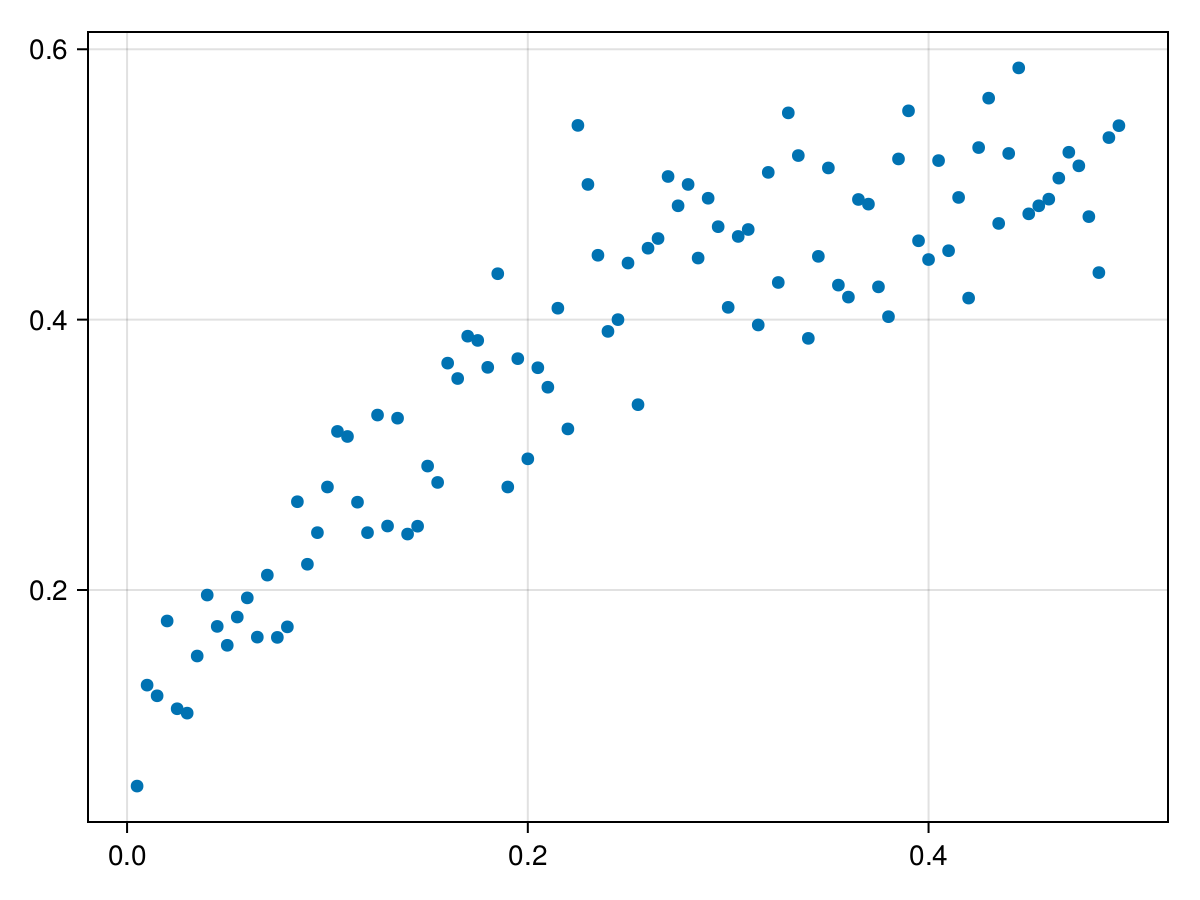

In [62]:
res = load("../Results/data/new_sims/overlap_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]
pvec = hcat(res["p"]...)

d = 0.005
xvec = d:d:1.0
stab = [stab[(i .< pvec[1,:] .< i + d)] |> mean for i = xvec]


plot((xvec), stab)


In [49]:
stab = [x.re < 0 for x = res["l"]]
stab = [stab[pvec[2,:] .== i] |> mean for i = unique(pvec[2,:])]

4-element Vector{Float64}:
 0.35291766586730616
 0.36192384769539077
 0.35407640803465934
 0.3997564935064935

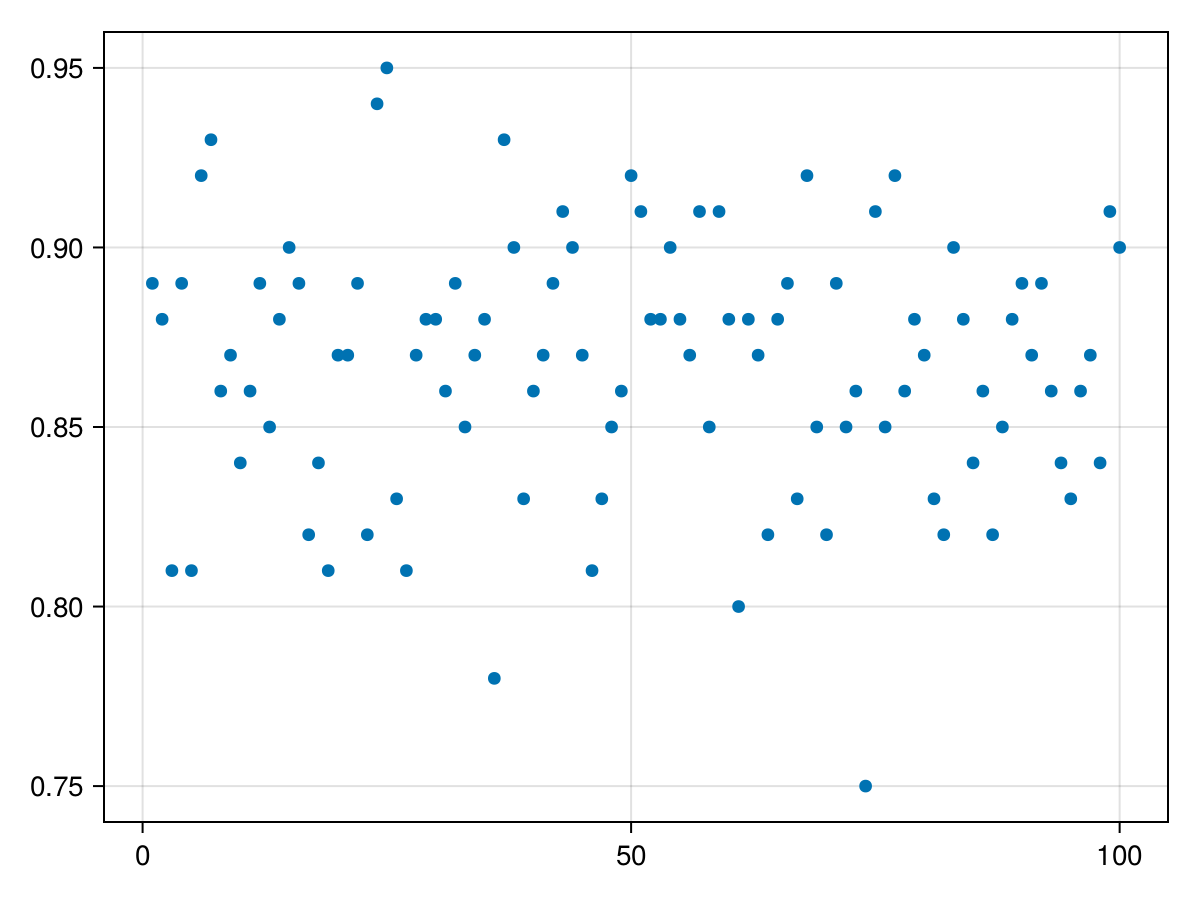

In [21]:
res = load("../Results/data/new_sims/coherence_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]

plot(mean(stab,dims=2)[:,1])

In [174]:
norm.(eigen(J).vectors) |> heatmap

LoadError: UndefVarError: `J` not defined

In [369]:
p.s.χ

1×10 Matrix{Float64}:
 0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  0.2

In [212]:
J .= 0
    #loop over consumers
    for i = 1:p.N
        for j = 1:p.N
            #dxi/dxi
            if i == j
                J[i,i] = p.s.α[i] * (1 - p.s.Λ[i]) * (p.e.gx[i] - p.e.mx[i])
            end
        end
        
        for a = 1:p.M
            #dxi/dya
            J[i, a + p.N] = p.s.α[i] * ( 
                (1 - p.s.Λ[i]) * (
                (p.e.gs[i] * p.s.χ[i,a] * p.e.fy[i,a])
                ) +
                (p.s.Λ[i] * p.e.λy[i,a])
            )
        end

    end

In [219]:
p.s.χ .* p.e.fy



100×200 Matrix{Float64}:
 0.0        0.030303   0.0        …  0.0        0.0  0.0  0.030303
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0344828  0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0357143  0.0357143     0.0        0.0  0.0  0.0357143
 0.0        0.0        0.0344828     0.0        0.0  0.0  0.0
 0.0        0.0285714  0.0        …  0.0        0.0  0.0  0.0285714
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0           0.0        0.0  0.0  0.030303
 0.0        0.0357143  0.0           0.0        0.0  0.0  0.0
 0.0555556  0.0555556  0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0        …  0.0357143  0.0  0.0  0.0357143
 0.0        0.0333333  0.0           0.0333333  0.0  0.0  0.0
 0.0357143  0.0357143  0.0           0.0357143  0.0  0.0  0.0
 ⋮                                ⋱                       
 0.037037   0.037037   0.0           0.0        0.0  0.0  0.0
 0.0        0.04    

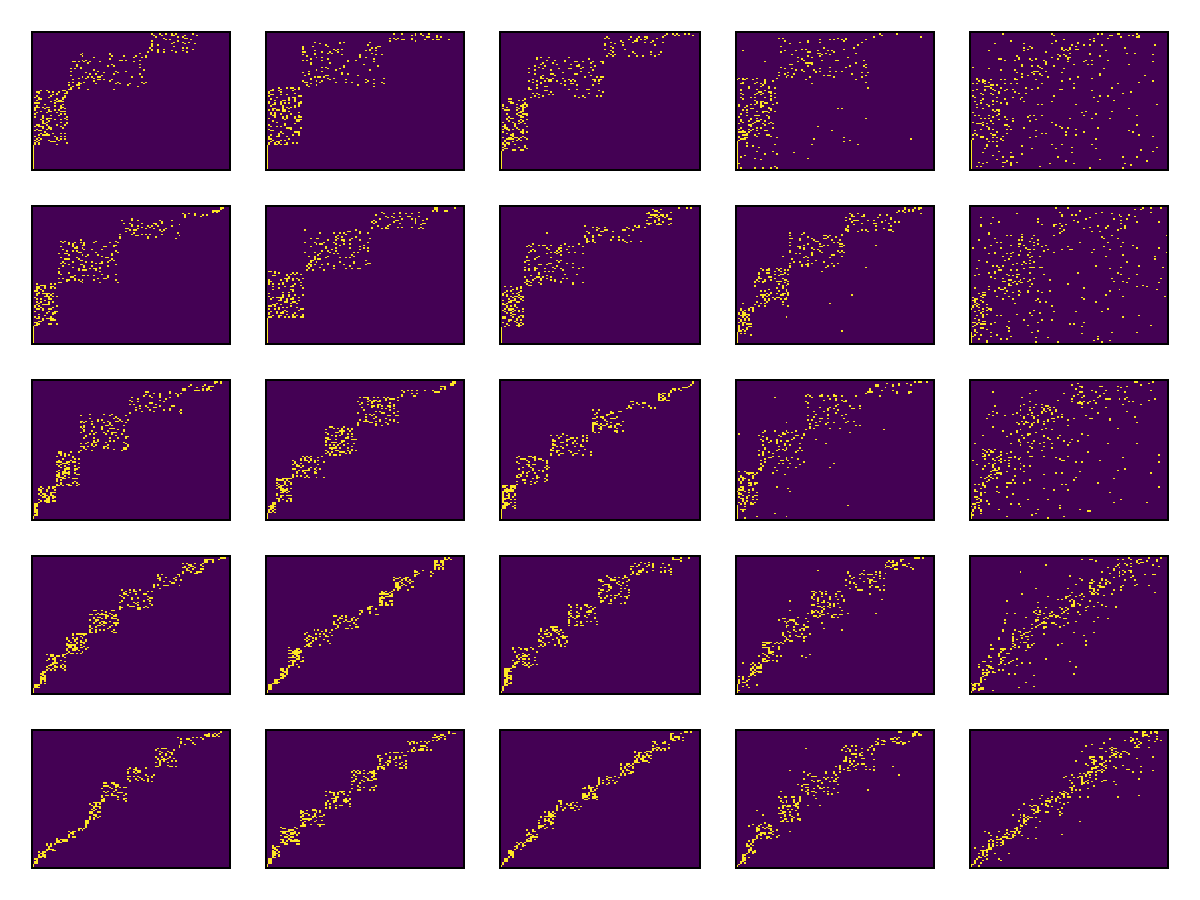

In [290]:
M = 100
λd = 3.0

h_vec = range(-2,2, length = 5)
T_vec = 10 .^ range(-2,0, length=5)

f = Figure()

for i = 1:5
    for j= 1:5
        ax = Axis(f[i,j])
        hidedecorations!(ax)
        heatmap!(ax, coherence_D(M,λd,h_vec[i],T_vec[j]))
    end
end
f

In [335]:
function get_switching_parameters(N,M,σ)

    gx = rand(Uniform(0.75,1.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(1.0,1.25)) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)

    # fy = ones(N,M)
    # hy = ones(N,M)
    
    λy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # ωy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # λy = zeros(N,M)

    iy = rand(Uniform(σ,0.5)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,iy,oy)
end

function coherence_D(M,λd,h,T)
    #create skeleton
    TL = fill(-Inf,M)
    TL[1] = 1
    
    D = zeros(M,M)
    p = 0
    for i = 2:M
        ind = 1:(i-1)
    #choose base
        pb = (TL[ind] / maximum(TL[ind])) .^ h
        b = sample(ind, Weights(pb[ind]))
        D[b,i] = 1
        TL[i] = TL[b] + 1
    end
    
    #sort by TL
    TLind = sortperm(TL)
    D = D[TLind, TLind]
    TL = TL[TLind]
    
    #add extra links
    k = rand(Poisson(λd), M)
    x = TL .- TL'
    pl = exp.(-abs.(x .- 1)/ T)
    pl[findall(D .== 1)] .= 0
    pl[diagind(pl)] .= 0
    
    for i = 2:M
        D[sample(1:M, Weights(pl[i,:]), k[i]), i] .= 1
    end
    
    return(D)
end

function random_community(N,M,f,h,T)
    U = rand(N,M) ./ (N*M)
    U[:,end] .= 0
    
    D = coherence_D(M,3.0,h,T)
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0.0
    
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(U,D,Λ)
    e = f(N,M, 0.1)
    u = MiCRM_stability.util_params(N,M,s,e)
    
    p = MiCRM_stability.Parameters(N,M,s,e,u)

    return(p)
end

random_community (generic function with 1 method)

In [334]:
N,M = 50,100
U = rand(N,M) ./ (N*M)
U[:,end] .= 0

D = coherence_D(M,3.0,h,T)
[D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
D[isnan.(D)] .= 0.0

Λ = fill(rand(),N)

s = MiCRM_stability.get_structural_params(U,D,Λ)

s.ψ

50×100×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0